# To-do
* Implement gradient descent function with M replaced by M+epsilon, and set epsilon to 0 past a certain threshold.
    * Use different learning rates for each region?
* The search for unitaries at the start is slow and not very effective. Scrap for now.
* May need to speed up gradient step for large number of unitaries by reducing duplication of effort in matrix multiplications.
* Rather than manually running for N steps, set convergence criteria. Upon convergence, unitarize once more re-run.
* There's a lot of swapping back between npc and np arrays, possible to keep in just np
* Maybe make the testdata object in the gradient descent step a dictionary or named tuple... (or an object...)

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [2]:
import tenpy
import tenpy.linalg.np_conserved as npc
from tenpy.algorithms import dmrg
from tenpy.networks.mps import MPS

In [3]:
from tenpy.networks.site import SpinSite, SpinHalfSite
from tenpy.models.lattice import Chain
from tenpy.models.model import CouplingModel, NearestNeighborModel, MPOModel

from tenpy.linalg.np_conserved import Array as npc_Array

In [4]:
import h5py
from tenpy.tools import hdf5_io

import os

# Load data

In [5]:
DATA_DIR = r"data/transverse_cluster_100_site_dmrg"

In [6]:
loaded_data = list()

for local_file_name in os.listdir(DATA_DIR):
    f_name = r"{}/{}".format(DATA_DIR, local_file_name)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        loaded_data.append(data)

# Optimize gradient descent

In [7]:
loaded_data[0]

{'paramters': {'B': 1.3},
 'wavefunction': <tenpy.networks.mps.MPS at 0x76063ababd50>}

In [8]:
test_psi = loaded_data[0]['wavefunction']

In [9]:
test_psi.get_B(0)

<npc.Array shape=(1, 2, 2) labels=['vL', 'p', 'vR']>

In [10]:
test_psi.get_B(0)

<npc.Array shape=(1, 2, 2) labels=['vL', 'p', 'vR']>

In [11]:
test_psi.canonical_form_finite()

In [12]:
test_psi.expectation_value("Sigmax", 50)

array([0.82995681])

In [13]:
B_test = test_psi.get_B(50)

In [14]:
left_leg = B_test.legs[0]

In [15]:
SL_test = npc.diag(test_psi.get_SL(50), left_leg, labels = ['vL', 'vR'])

In [16]:
SL_test

<npc.Array shape=(8, 8) labels=['vL', 'vR']>

In [17]:
B_test

<npc.Array shape=(8, 2, 8) labels=['vL', 'p', 'vR']>

In [18]:
def to_npc_array(np_X):
    npc_X = (
        npc_Array
        .from_ndarray_trivial(
            np.array(np_X, dtype='complex'),
            dtype=np.complex_,
            labels=['p', 'p*']
        )
    )
    return npc_X

In [19]:
npc_X = (
    npc_Array
    .from_ndarray_trivial(
        np.array([[0,1],[1,0]], dtype='complex'),
        dtype=np.complex_,
        labels=['p', 'p*']
    )
)

In [20]:
npc_X

<npc.Array shape=(2, 2) labels=['p', 'p*']>

In [21]:
def partial_contract_ops(psi, ops_list, starting_index):
    B0 = psi.get_B(starting_index)
    op0 = ops_list[0]

    t = npc.tensordot(B0, op0, (['p',], ['p*',]))
    t = npc.tensordot(t, B0.conj(), (['p',], ['p*',]))
    
    for i, op in enumerate(ops_list[1:], start=starting_index + 1):
        b = psi.get_B(i)
        t = npc.tensordot(t, b, (['vR',], ['vL',]))
        t = npc.tensordot(t, b.conj(), (['vR*',], ['vL*',]))
        t = npc.tensordot(t, op, (['p', 'p*'], ['p*', 'p']))

    return t

In [22]:
starting_index = 40
ops_list = [npc_X,]*20

In [23]:
B0 = test_psi.get_B(starting_index)

In [24]:
test_psi.L

100

In [25]:
B0

<npc.Array shape=(8, 2, 8) labels=['vL', 'p', 'vR']>

In [26]:
op0 = ops_list[0]

In [27]:
t = npc.tensordot(B0, op0, (['p',], ['p*',]))
t = npc.tensordot(t, B0.conj(), (['p',], ['p*',]))

In [28]:
t

<npc.Array shape=(8, 8, 8, 8) labels=['vL', 'vR', 'vL*', 'vR*']>

In [29]:
test_t = partial_contract_ops(test_psi, [npc_X,]*20, 40)

In [30]:
test_t

<npc.Array shape=(8, 8, 8, 8) labels=['vL', 'vL*', 'vR', 'vR*']>

In [31]:
test_psi.expectation_value_multi_sites([npc_X,]*20, 40)

array(0.64194101)

In [32]:
exp_test_t = npc.trace(test_t, leg1='vR', leg2='vR*')

In [33]:
left_leg = test_psi.get_B(40).legs[0]
exp_SL_test = npc.diag(test_psi.get_SL(40), left_leg, labels = ['vL', 'vR'])

In [34]:
exp_test_t = npc.tensordot(exp_test_t, exp_SL_test, (['vL',], ['vR',]))
exp_test_t = npc.tensordot(exp_test_t, exp_SL_test.conj(), (['vL*',], ['vR*',]))

In [35]:
npc.trace(exp_test_t, leg1='vL', leg2='vL*')

(0.6419410096319128+0j)

In [36]:
def multiply_transfer_matrices(t1, t2):
    return npc.tensordot(t1, t2, (['vR', 'vR*'], ['vL', 'vL*']))

In [37]:
def get_transfer_matrix_from_unitary(psi, unitary, index):
    u = to_npc_array(unitary)
    b = psi.get_B(index)
    t = npc.tensordot(b, u, (['p',], ['p*']))
    t = npc.tensordot(t, b.conj(), (['p',], ['p*']))
    return t

In [38]:
def get_transfer_matrices_from_unitary_list(psi, unitaries, starting_index):
    transfer_matrices = [
        get_transfer_matrix_from_unitary(psi, u, i)
        for i, u in enumerate(unitaries, start=starting_index)
    ]
    return transfer_matrices

In [39]:
from functools import reduce

In [40]:
def matrix_element(left_environment, left_transfer_matrices,
                   symmetry_block_tm, right_transfer_matrices):
    transfer_matrices = (
        left_transfer_matrices +
        [symmetry_block_tm,] +
        right_transfer_matrices
    )

    t_with_open_right_end = reduce(
        multiply_transfer_matrices,
        transfer_matrices,
        left_environment
    )

    return npc.trace(t_with_open_right_end, leg1='vR', leg2='vR*')

In [41]:
def matrix_gradient_left_unitary(psi, left_environment, left_transfer_matrices,
                    symmetry_block_tm, right_transfer_matrices,
                    psi_index, unitary_index):

    environment_left_of_site = reduce(
        multiply_transfer_matrices,
        left_transfer_matrices[:unitary_index],
        left_environment
    )

    environment_right_of_site = reduce(
        multiply_transfer_matrices,
        (
            left_transfer_matrices[unitary_index+1:] +
            [symmetry_block_tm,] +
            right_transfer_matrices
        )
    )

    environment_right_of_site = npc.trace(
        environment_right_of_site, leg1='vR', leg2='vR*'
    )

    b = psi.get_B(psi_index)
    t = npc.tensordot(environment_left_of_site, b.conj(), (['vR*',], ['vL*',]))
    t = npc.tensordot(t, b, (['vR',], ['vL',]))
    t = npc.tensordot(t, environment_right_of_site, (['vR','vR*'], ['vL', 'vL*']))

    """
    if t.get_leg_index('p') == 1:
        t.itranspose()
    """

    return t.to_ndarray()

In [42]:
def matrix_gradient_right_unitary(psi, left_environment, left_transfer_matrices,
                    symmetry_block_tm, right_transfer_matrices,
                    psi_index, unitary_index):

    environment_left_of_site = reduce(
        multiply_transfer_matrices,
        (
            left_transfer_matrices +
            [symmetry_block_tm,] + 
            right_transfer_matrices[:unitary_index]
        ),
        left_environment
    )

    b = psi.get_B(psi_index)
    t = npc.tensordot(environment_left_of_site, b.conj(), (['vR*',], ['vL*',]))
    t = npc.tensordot(t, b, (['vR',], ['vL',]))

    
    t = reduce(
        multiply_transfer_matrices,
        right_transfer_matrices[unitary_index+1:],
        t
    )

    t = npc.trace(t, leg1='vR', leg2='vR*')

    """
    if t.get_leg_index('p') == 1:
        t.itranspose()
    """
    
    return t.to_ndarray()

In [43]:
def compute_symmetry_block_transfer_matrix(psi, symmetry_op_list, starting_index):
    transfer_matrices = (
        get_transfer_matrix_from_unitary(psi, op, index)
        for index, op in enumerate(symmetry_op_list, start=starting_index)
    )

    symmetry_block_transfer_matrix = reduce(
        multiply_transfer_matrices,
        transfer_matrices
    )

    return symmetry_block_transfer_matrix

In [44]:
from scipy.stats import unitary_group

In [45]:
unitary_sampler = unitary_group(2)

In [46]:
np_I = np.array([[1,0], [0,1]])
np_X = np.array([[0,1], [1,0]])
np_Y = np.array([[0,-1j], [1j, 0]])
np_Z = np.array([[1,0],[0,-1]])

In [47]:
pauli_matrices = [np_I, np_X, np_Y, np_Z]

In [48]:
from itertools import product

In [49]:
def initialize_unitaries(psi, left_environment, num_unitary_width,
                         symmetry_block_tm, starting_index, len_symmetry_block):
    left_unitaries = [unitary_sampler.rvs() for _ in range(num_unitary_width)]
    right_unitaries = [unitary_sampler.rvs() for _ in range(num_unitary_width)]

    left_transfer_matrices = list()
    for i, u in enumerate(left_unitaries, start=starting_index):
        l = list()
        for p in pauli_matrices:
            up = u.dot(p)
            tm = get_transfer_matrix_from_unitary(psi, up, i)
            l.append(tm)
        left_transfer_matrices.append(l)

    
    right_transfer_matrices = list()
    start = starting_index + num_unitary_width + len_symmetry_block
    for i, u in enumerate(right_unitaries, start=start):
        l = list()
        for p in pauli_matrices:
            up = u.dot(p)
            tm = get_transfer_matrix_from_unitary(psi, up, i)
            l.append(tm)
        right_transfer_matrices.append(l)

    left_transfer_matrix_index_enumerator = product(
        *([range(len(pauli_matrices)),]*num_unitary_width)
    )
    
    right_transfer_matrix_index_enumerator = product(
        *([range(len(pauli_matrices)),]*num_unitary_width)
    )

    min_loss = 1.0
    
    for u_l, i_l in zip(product(*left_transfer_matrices), left_transfer_matrix_index_enumerator):
        for u_r, i_r in zip(product(*right_transfer_matrices), right_transfer_matrix_index_enumerator):
            m = matrix_element(
                left_environment, list(u_l), symmetry_block_tm, list(u_r)
            )
            loss = 1-np.abs(m)**2
            if loss < min_loss:
                min_loss = loss
                i_l_min = i_l
                i_r_min = i_r

    for i, index in enumerate(i_l_min):
        u = left_unitaries[i].dot(pauli_matrices[index])
        left_unitaries[i] = u

    for i, index in enumerate(i_r_min):
        u = right_unitaries[i].dot(pauli_matrices[index])
        right_unitaries[i] = u

    return (left_unitaries, right_unitaries)

In [50]:
def grad_descent_setup(psi, num_unitary_width, symmetry_op_list):
    # Initialize unitaries, using "grid" search.
    # Compute symmetry_block_tm

    num_sites = psi.L
    num_symmetry_sites = len(symmetry_op_list)
    num_unitary_sites = num_unitary_width*2

    starting_index = (num_sites - (num_symmetry_sites + num_unitary_sites))//2
    symmetry_starting_index = starting_index + num_unitary_width

    left_leg = psi.get_B(starting_index).legs[0]
    SL = npc.diag(psi.get_SL(starting_index), left_leg, labels = ['vL', 'vR'])
    left_environment = npc.tensordot(SL, SL.conj(), (['vL',], ['vL*',]))

    symmetry_block_transfer_matrix = compute_symmetry_block_transfer_matrix(
        psi, symmetry_op_list, symmetry_starting_index
    )

    left_unitaries = [unitary_sampler.rvs() for _ in range(num_unitary_width)]
    right_unitaries = [unitary_sampler.rvs() for _ in range(num_unitary_width)]
    
    losses = list()
    unitary_scores = list()

    out = (
        psi,
        left_environment,
        symmetry_block_transfer_matrix,
        left_unitaries,
        right_unitaries,
        starting_index,
        num_symmetry_sites,
        losses,
        unitary_scores
    )

    return out

In [51]:
def projector(U, delta_U):
    M1 = (U.conj().T).dot(delta_U)
    M2 = 0.5*(M1 - M1.conj().T)
    M3 = U.dot(M2)

    return M3

In [52]:
UNITARY_TOL = 0.005

In [53]:
def unitary_test(U):
    return np.max(np.abs(U.conj().T.dot(U)-np.identity(len(U))))

In [54]:
def unitarize_matrix(U):
    L,S,R = np.linalg.svd(U)
    return L.dot(R)

In [55]:
def loss(psi, symmetry_operations, left_unitaries, right_unitaries):
    M = matrix_element(psi, symmetry_operations, left_unitaries, right_unitaries)
    return 1 - np.abs(M)**2

In [56]:
def grad_descent_step(psi, left_environment, symmetry_block_tm, left_unitaries,
                      right_unitaries, starting_index, len_symmetry_block,
                      losses, unitary_scores, eta=0.03):
    
    left_transfer_matrices = get_transfer_matrices_from_unitary_list(
        psi, left_unitaries, starting_index
    )
    right_transfer_matrices = get_transfer_matrices_from_unitary_list(
        psi, right_unitaries, starting_index + len(left_unitaries) + len_symmetry_block
    )
    
    expectation = matrix_element(
        left_environment, left_transfer_matrices, symmetry_block_tm,
        right_transfer_matrices
    )

    left_matrix_gradients = list()
    for i, u in enumerate(left_transfer_matrices):
        psi_index = starting_index + i
        grad = matrix_gradient_left_unitary(
            psi, left_environment, left_transfer_matrices, symmetry_block_tm,
            right_transfer_matrices, psi_index, i
        )
        left_matrix_gradients.append(grad)

    right_matrix_gradients = list()
    for i, u in enumerate(right_transfer_matrices):
        psi_index = (
            starting_index +
            len_symmetry_block +
            len(left_unitaries) +
            i
        )
        grad = matrix_gradient_right_unitary(
            psi, left_environment, left_transfer_matrices, symmetry_block_tm,
            right_transfer_matrices, psi_index, i
        )
        right_matrix_gradients.append(grad)

    abs_exp = np.abs(expectation)
    pol_exp = expectation/abs_exp
    
    if abs_exp < 0.9:
        m = pol_exp
    else:
        m = expectation
    
    for i, m_grad in enumerate(left_matrix_gradients):
        u = left_unitaries[i]
        u_grad = -2*m*np.conj(m_grad)
        left_unitaries[i] += -eta*projector(u, u_grad)

    for i, m_grad in enumerate(right_matrix_gradients):
        u = right_unitaries[i]
        u_grad = -2*m*np.conj(m_grad)
        right_unitaries[i] += -eta*projector(u, u_grad)

    all_unitaries = left_unitaries + right_unitaries

    any_unitary_fail = any(
        unitary_test(u) > UNITARY_TOL
        for u in all_unitaries
    )

    if any_unitary_fail:
        for i in range(len(left_unitaries)):
            u = left_unitaries[i]
            left_unitaries[i] = unitarize_matrix(u)
        for i in range(len(right_unitaries)):
            u = right_unitaries[i]
            right_unitaries[i] = unitarize_matrix(u)

    unitary_score = max(unitary_test(u) for u in left_unitaries + right_unitaries)
    unitary_scores.append(unitary_score)

    losses.append(1 - np.abs(expectation)**2)

# Testing

In [57]:
loaded_data[0]

{'paramters': {'B': 1.3},
 'wavefunction': <tenpy.networks.mps.MPS at 0x76063ababd50>}

In [58]:
psi = next(
    d['wavefunction']
    for d in loaded_data
    if d['paramters']['B'] == 0
)   

In [59]:
(
    psi,
    left_environment,
    symmetry_block_tm,
    left_unitaries,
    right_unitaries,
    starting_index,
    len_symmetry_block,
    losses,
    unitary_scores
) = grad_descent_setup(psi, 2, [np_X, np_I]*10)

In [60]:
for _ in range(100):
    grad_descent_step(
        psi,
        left_environment,
        symmetry_block_tm,
        left_unitaries,
        right_unitaries,
        starting_index,
        len_symmetry_block,
        losses,
        unitary_scores,
        eta=0.1
    )

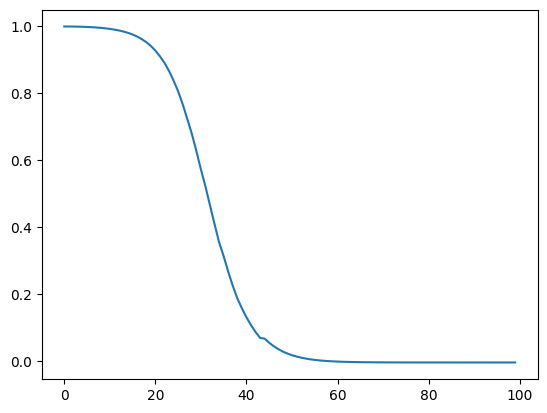

In [61]:
plt.plot(losses)

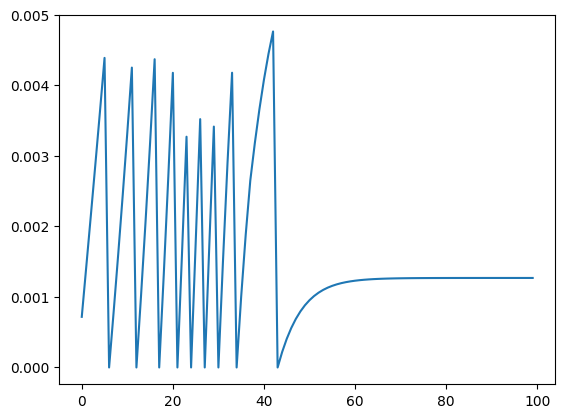

In [62]:
plt.plot(unitary_scores)

Other symmetry action

In [63]:
data_b0_s2 = grad_descent_setup(psi, 2, [np_X, np_X]*10)

In [64]:
for _ in range(100):
    grad_descent_step(*data_b0_s2, eta=0.1)

In [65]:
(*_, losses, unitary_scores) = data_b0_s2

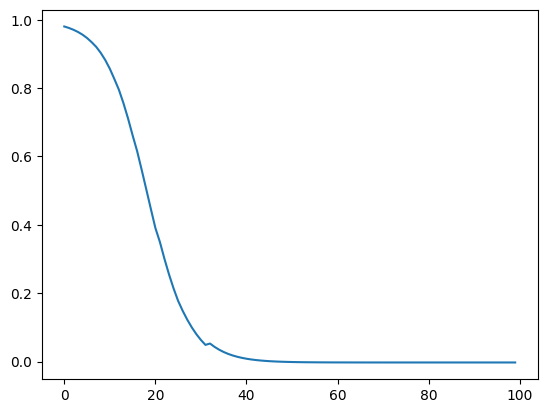

In [66]:
plt.plot(losses)

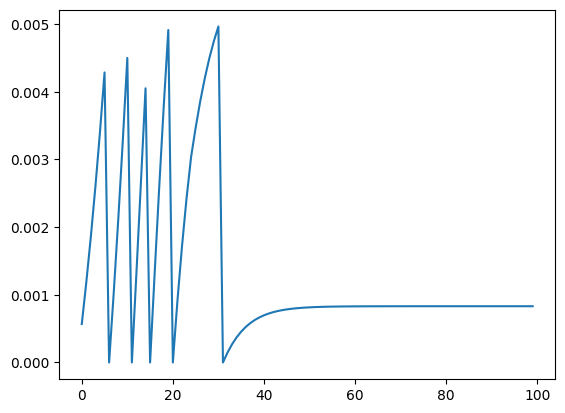

In [67]:
plt.plot(unitary_scores)

### Extract cohomology class

In [59]:
(
    psi,
    left_environment,
    symmetry_block_tm,
    left_unitaries,
    right_unitaries,
    starting_index,
    len_symmetry_block,
    losses,
    unitary_scores
) = grad_descent_setup(psi, 2, [np_X, np_I]*10)

In [38]:
def get_transfer_matrices_from_unitary_list(psi, unitaries, starting_index):
    transfer_matrices = [
        get_transfer_matrix_from_unitary(psi, u, i)
        for i, u in enumerate(unitaries, start=starting_index)
    ]
    return transfer_matrices

In [39]:
from functools import reduce

In [40]:
def matrix_element(left_environment, left_transfer_matrices,
                   symmetry_block_tm, right_transfer_matrices):
    transfer_matrices = (
        left_transfer_matrices +
        [symmetry_block_tm,] +
        right_transfer_matrices
    )

    t_with_open_right_end = reduce(
        multiply_transfer_matrices,
        transfer_matrices,
        left_environment
    )

    return npc.trace(t_with_open_right_end, leg1='vR', leg2='vR*')

In [68]:
"""
This was a previous implementation of the cohomology phase extraction I was working on.
Turns out we don't need the exact phase of the unitaries, as it cancels out
in the final expression anyway.

def extract_left_right_cohomology_phases(psi, left_environment,
    symmetry_block_tm, left_unitaries_1, left_unitaries_2, right_unitaries_1,
    right_unitaries_2, starting_index, len_symmetry_block):
    assert len(left_unitaries_1) == len(left_unitaries_2)
    assert len(right_unitaries_1) == len(right_unitaries_2)

    right_starting_index = (
        starting_index +
        len(left_unitaries_1) +
        len_symmetry_block_tm
    )

    # Compute phase of unitaries.
    ## Compute 
    left_tms_1 = get_transfer_matrices_from_unitary_list(
        psi, left_unitaries_1, starting_index
    )
    left_tms_2 = get_transfer_matrices_from_unitary_list(
        psi, left_unitaries_2, starting_index
    )
    right_tms_1 = get_transfer_matrices_from_unitary_list(
        psi, right_unitaries_1, starting_index
    )
    right_tms_2 = get_transfer_matrices_from_unitary_list(
        psi, right_unitaries_2, starting_index
    )

    ## Compute expectation values.
    m1 = matrix_element(
        left_environment, left_tms_1, symmetry_block_tm, right_tms_1
    )
    m2 = matrix_element(
        left_environment, left_tms_2, symmetry_block_tm, right_tms_2
    )

    # Compute "missing" phases.
    p1 = np.conj(m1)/(np.abs(m1))
    p2 = np.conj(m2)/(np.abs(m2))

    # Compute left and right unitary product.

    # Approximate output as phase time's identity.
"""

'\nThis was a previous implementation of the cohomology phase extraction I was working on.\nTurns out we don\'t need the exact phase of the unitaries, as it cancels out\nin the final expression anyway.\n\ndef extract_left_right_cohomology_phases(psi, left_environment,\n    symmetry_block_tm, left_unitaries_1, left_unitaries_2, right_unitaries_1,\n    right_unitaries_2, starting_index, len_symmetry_block):\n    assert len(left_unitaries_1) == len(left_unitaries_2)\n    assert len(right_unitaries_1) == len(right_unitaries_2)\n\n    right_starting_index = (\n        starting_index +\n        len(left_unitaries_1) +\n        len_symmetry_block_tm\n    )\n\n    # Compute phase of unitaries.\n    ## Compute \n    left_tms_1 = get_transfer_matrices_from_unitary_list(\n        psi, left_unitaries_1, starting_index\n    )\n    left_tms_2 = get_transfer_matrices_from_unitary_list(\n        psi, left_unitaries_2, starting_index\n    )\n    right_tms_1 = get_transfer_matrices_from_unitary_list(\n 

In [76]:
def extract_cohomology_phase(u1, u2):
    out = u1.dot(u2)
    out = out.dot(np.conj(u1).T)
    out = out.dot(np.conj(u2).T)

    avg_tr = np.trace(out)/(out.shape[0])
    phase = avg_tr/(np.abs(avg_tr))

    return phase

In [87]:
from operator import mul

In [88]:
def prod(l):
    return reduce(mul, l, 1)

In [89]:
def extract_left_right_cohomology_phases(left_unitaries_1, left_unitaries_2,
                                         right_unitaries_1, right_unitaries_2):
    assert len(left_unitaries_1) == len(left_unitaries_2)
    assert len(right_unitaries_1) == len(right_unitaries_2)

    left_phases = [
        extract_cohomology_phase(u1, u2)
        for u1, u2 in zip(left_unitaries_1, left_unitaries_2)
    ]

    right_phases = [
        extract_cohomology_phase(u1, u2)
        for u1, u2 in zip(right_unitaries_1, right_unitaries_2)
    ]

    left_phase = prod(left_phases)
    right_phase = prod(right_phases)

    return (left_phase, right_phase)

In [72]:
left_unitaries_1, right_unitaries_1 = left_unitaries, right_unitaries

In [71]:
left_unitaries_2, right_unitaries_2 = data_b0_s2[3:5]

In [90]:
extract_left_right_cohomology_phases(left_unitaries_1, left_unitaries_2,
                                         right_unitaries_1, right_unitaries_2)

((-1-6.929016708936416e-17j), (-1+2.7711792115863796e-17j))

## Test on other wavefunctions
### B=0.1

In [91]:
psi_b01 = next(
    d['wavefunction']
    for d in loaded_data
    if d['paramters']['B'] == 0.1
)   

In [116]:
data_b01_sl = grad_descent_setup(psi_b01, 2, [np_X, np_I]*20)

In [117]:
for _ in range(200):
    grad_descent_step(*data_b01_sl, eta=0.1)

In [118]:
(*_, losses, unitary_scores) = data_b01_sl

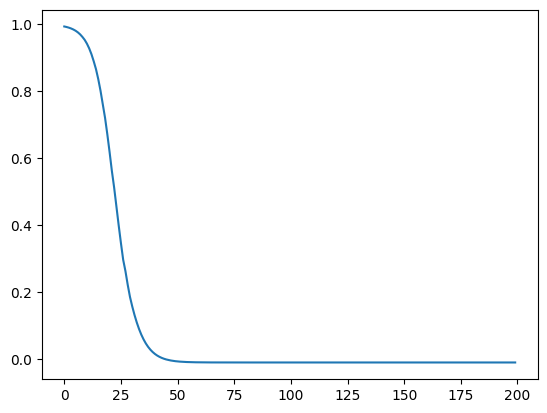

In [119]:
plt.plot(losses)

In [120]:
losses[-1]

-0.009043223376764775

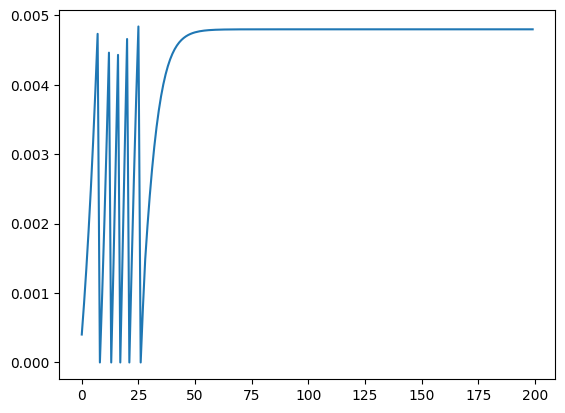

In [121]:
plt.plot(unitary_scores)

In [122]:
data_b01_sr = grad_descent_setup(psi_b01, 2, [np_I, np_X]*20)

In [123]:
for _ in range(200):
    grad_descent_step(*data_b01_sr, eta=0.1)

In [124]:
(*_, losses, unitary_scores) = data_b01_sr

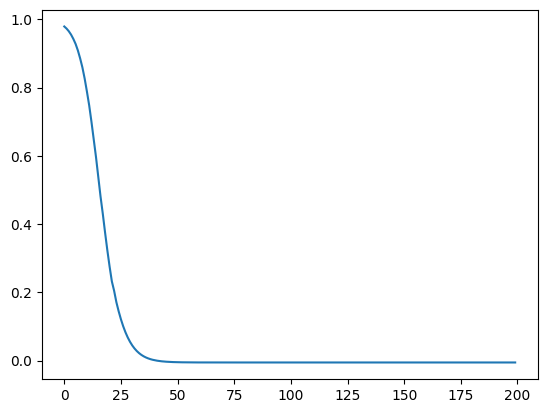

In [125]:
plt.plot(losses)

In [126]:
losses[-1]

-0.005602938335360186

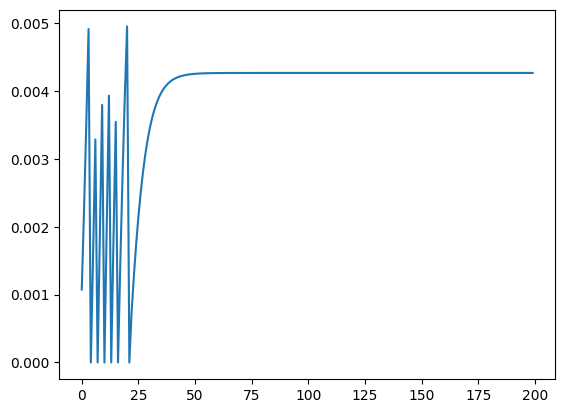

In [127]:
plt.plot(unitary_scores)

In [128]:
data_b01_sb = grad_descent_setup(psi_b01, 2, [np_X, np_X]*20)

In [139]:
for _ in range(100):
    grad_descent_step(*data_b01_sb, eta=0.01)

In [140]:
(*_, losses, unitary_scores) = data_b01_sb

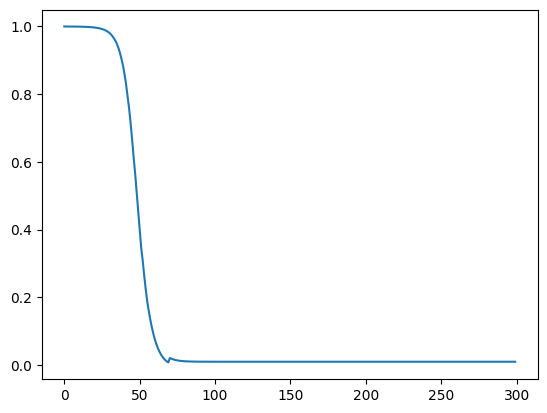

In [141]:
plt.plot(losses)

In [142]:
losses[-1]

0.009454580047259187

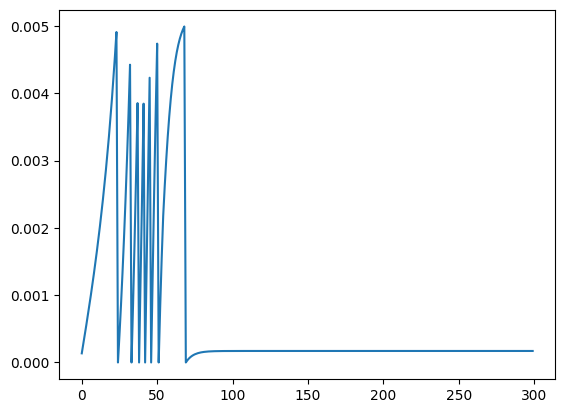

In [143]:
plt.plot(unitary_scores)

In [144]:
extract_left_right_cohomology_phases(
    data_b01_sl[3],
    data_b01_sr[3],
    data_b01_sl[4],
    data_b01_sr[4]
)

((-1+2.7575401284143788e-17j), (-1-2.754686230066858e-17j))

In [145]:
extract_left_right_cohomology_phases(
    data_b01_sl[3],
    data_b01_sb[3],
    data_b01_sl[4],
    data_b01_sb[4]
)

((-1-3.462343852730723e-17j), (-1-5.520328643213065e-17j))

In [146]:
extract_left_right_cohomology_phases(
    data_b01_sr[3],
    data_b01_sb[3],
    data_b01_sr[4],
    data_b01_sb[4]
)

((-1+5.941427932206406e-20j), (-1+2.7733116340784574e-17j))

### B=0.5

In [304]:
b_parameters = list(d['paramters']['B'] for d in loaded_data)

In [305]:
b_parameters

[1.3,
 0.4,
 1.7000000000000002,
 1.6,
 0.1,
 1.9000000000000001,
 1.2000000000000002,
 1.8,
 1.4000000000000001,
 2.0,
 0.6000000000000001,
 0.5,
 0.30000000000000004,
 1.5,
 0.9,
 0.7000000000000001,
 0.2,
 0.0,
 1.1,
 0.8,
 1.0]

That's annoying...

In [306]:
psi_05 = next(
    d['wavefunction']
    for d in loaded_data
    if d['paramters']['B'] == 0.5
)   

In [333]:
data_b05_sl_w2 = grad_descent_setup(psi_05, 2, [np_X, np_I]*20)

In [334]:
for _ in range(500):
    grad_descent_step(*data_b05_sl_w2, eta=0.1)

In [335]:
(*_, losses, unitary_scores) = data_b05_sl_w2

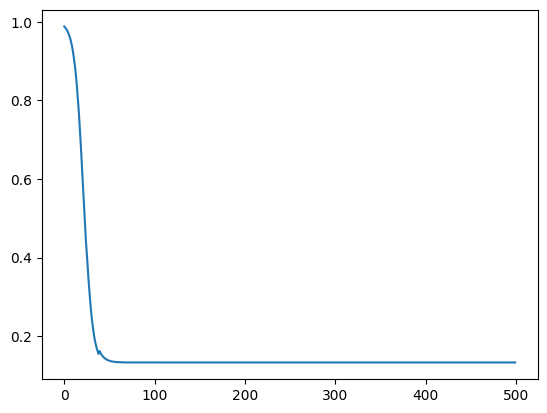

In [336]:
plt.plot(losses)

In [337]:
losses[-1]

0.13269730086413245

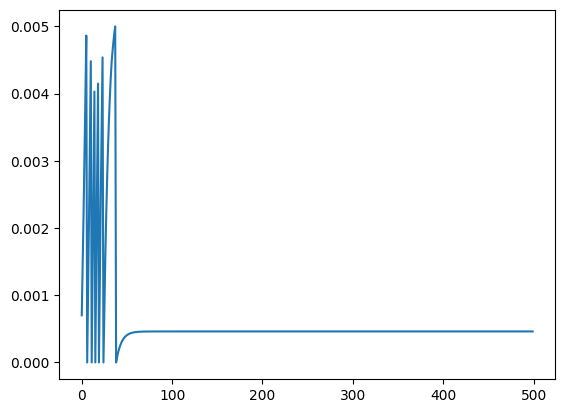

In [338]:
plt.plot(unitary_scores)

In [339]:
data_b05_sr_w2 = grad_descent_setup(psi_05, 2, [np_I, np_X]*20)

In [340]:
for _ in range(500):
    grad_descent_step(*data_b05_sr_w2, eta=0.1)

In [341]:
(*_, losses, unitary_scores) = data_b05_sr_w2

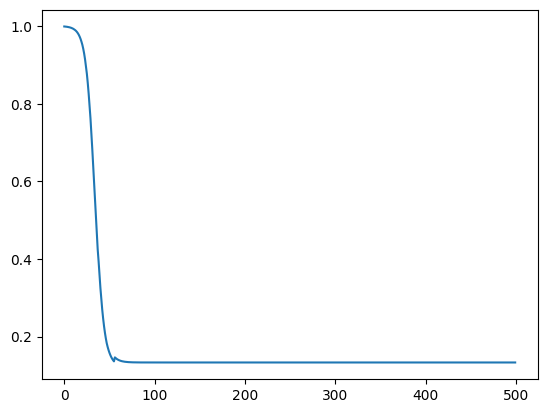

In [342]:
plt.plot(losses)

In [343]:
losses[-1]

0.13338590701210895

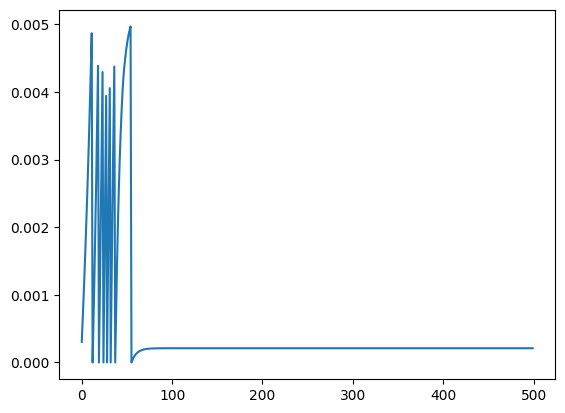

In [344]:
plt.plot(unitary_scores)

In [361]:
data_b05_sb_w2 = grad_descent_setup(psi_05, 2, [np_X, np_X]*20)

In [362]:
for _ in range(500):
    grad_descent_step(*data_b05_sb_w2, eta=0.1)

In [363]:
(*_, losses, unitary_scores) = data_b05_sb_w2

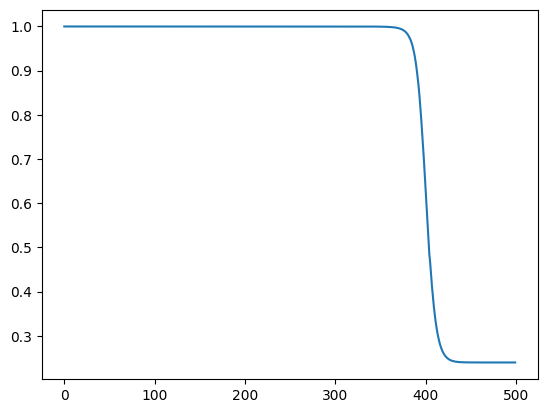

In [364]:
plt.plot(losses)

In [365]:
losses[-1]

0.23946855345326556

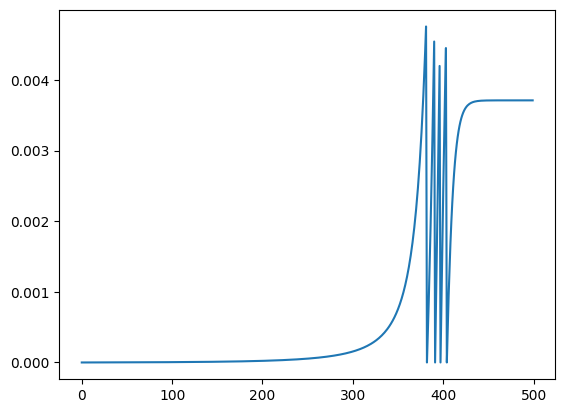

In [366]:
plt.plot(unitary_scores)

This loss doesn't seem to decrease if the unitary wdith is increased...

In [367]:
data_b05_sb_w4 = grad_descent_setup(psi_05, 4, [np_X, np_X]*20)

In [368]:
for _ in range(500):
    grad_descent_step(*data_b05_sb_w4, eta=0.1)

In [369]:
(*_, losses, unitary_scores) = data_b05_sb_w4

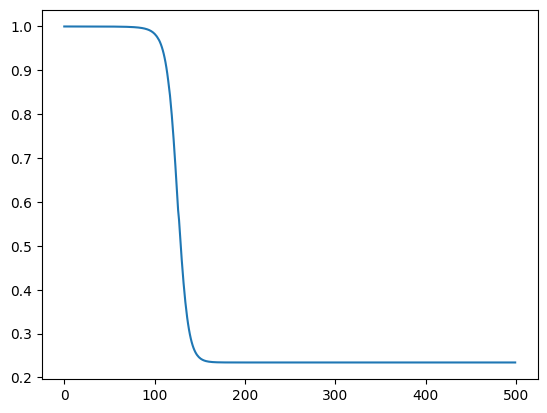

In [370]:
plt.plot(losses)

In [371]:
(losses[-1], unitary_scores[-1])

(0.2341153764059597, 0.004114781742008855)

Extract cohomology phases

In [372]:
extract_left_right_cohomology_phases(
    data_b05_sl_w2[3],
    data_b05_sr_w2[3],
    data_b05_sl_w2[4],
    data_b05_sr_w2[4]
)

((-1-2.7745597420871688e-17j), (-1+8.32240925953426e-17j))

In [373]:
extract_left_right_cohomology_phases(
    data_b05_sl_w2[3],
    data_b05_sb_w2[3],
    data_b05_sl_w2[4],
    data_b05_sb_w2[4]
)

((-1-8.29506208894587e-17j), (-1+2.764656813063247e-17j))

In [374]:
extract_left_right_cohomology_phases(
    data_b05_sr_w2[3],
    data_b05_sb_w2[3],
    data_b05_sr_w2[4],
    data_b05_sb_w2[4]
)

((-1+2.767045015195897e-17j), (-1+0j))

Not using this code anymore...
Add more unitaries, and continue learning.

In [314]:
left_unitaries = data_b05_sl_w2[3].copy()
right_unitaries = data_b05_sl_w2[4].copy()

In [315]:
identity_matrix = np.array([[1,0], [0,1]], dtype='complex128')

In [316]:
left_unitaries = [identity_matrix,] + left_unitaries
right_unitaries.append(identity_matrix)

In [317]:
len(left_unitaries), len(right_unitaries)

(3, 3)

In [321]:
padded_data_b05_sl_w3 = (
    data_b05_sl_w2[:3] +
    (left_unitaries, right_unitaries) +
    (starting_index - 1,) +
    data_b05_sl_w2[6:]
)

In [322]:
len(padded_data_b05_sl_w3) == len(data_b05_sl_w2)

True

In [323]:
for _ in range(500):
    grad_descent_step(*padded_data_b05_sl_w3, eta=0.1)

In [324]:
(*_, losses, unitary_scores) = padded_data_b05_sl_w3

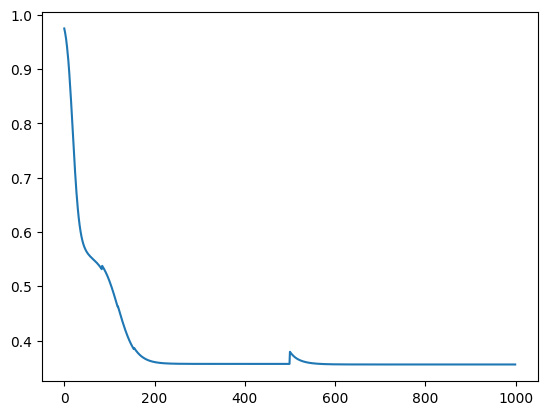

In [325]:
plt.plot(losses)

In [326]:
losses[-1]

0.35584537647591674

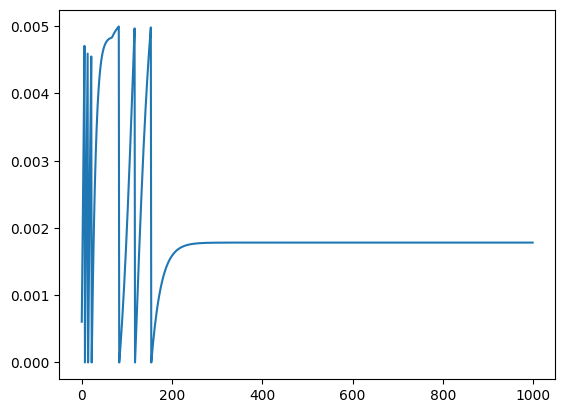

In [327]:
plt.plot(unitary_scores)

No improvement, so start again

In [307]:
data_b05_sl_w3 = grad_descent_setup(test_psi, 2, [np_X, np_I]*20)

In [309]:
for _ in range(500):
    grad_descent_step(*data_b05_sl_w2, eta=0.1)

In [310]:
(*_, losses, unitary_scores) = data_b05_sl_w2

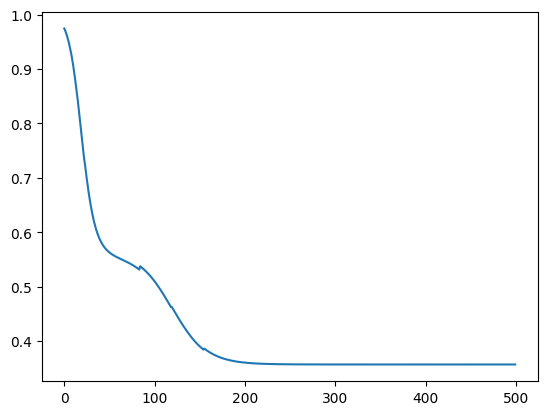

In [311]:
plt.plot(losses)

In [312]:
losses[-1]

0.35690881649743733

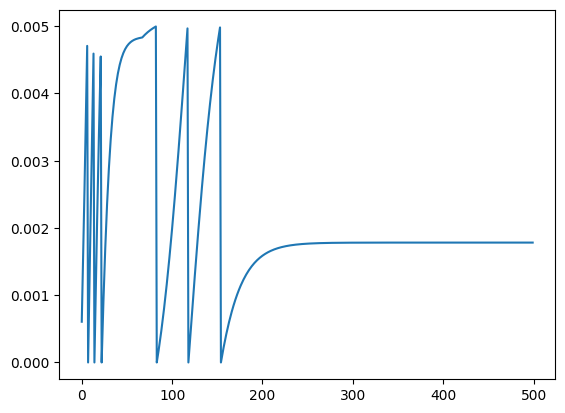

In [313]:
plt.plot(unitary_scores)

### B=0.9

In [375]:
psi_09 = next(
    d['wavefunction']
    for d in loaded_data
    if d['paramters']['B'] == 0.9
)   

In [425]:
data_b09_sl_w2 = grad_descent_setup(psi_09, 2, [np_X, np_I]*30)

In [426]:
for _ in range(500):
    grad_descent_step(*data_b09_sl_w2, eta=0.1)

In [427]:
(*_, losses, unitary_scores) = data_b09_sl_w2

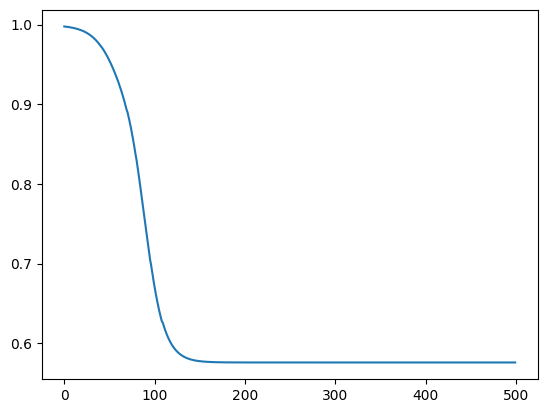

In [428]:
plt.plot(losses)

In [429]:
(losses[-1], unitary_scores[-1])

(0.5759542651599493, 0.003267842297449697)

In [430]:
data_b09_sr_w2 = grad_descent_setup(psi_09, 2, [np_I, np_X]*30)

In [431]:
for _ in range(500):
    grad_descent_step(*data_b09_sr_w2, eta=0.1)

In [432]:
(*_, losses, unitary_scores) = data_b09_sr_w2

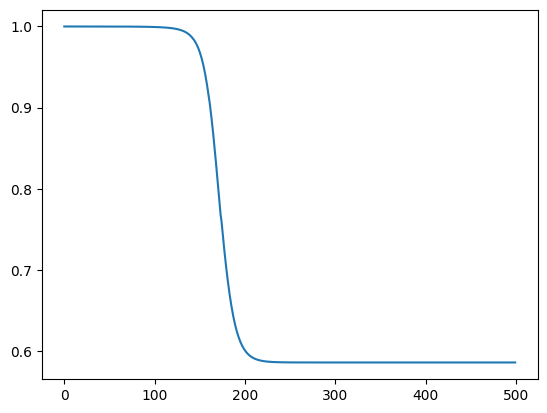

In [433]:
plt.plot(losses)

In [434]:
(losses[-1], unitary_scores[-1])

(0.5861893555134441, 0.004270364522992898)

In [440]:
data_b09_sb_w2 = grad_descent_setup(psi_09, 2, [np_X, np_X]*30)

In [441]:
for _ in range(500):
    grad_descent_step(*data_b09_sb_w2, eta=0.1)

In [442]:
(*_, losses, unitary_scores) = data_b09_sb_w2

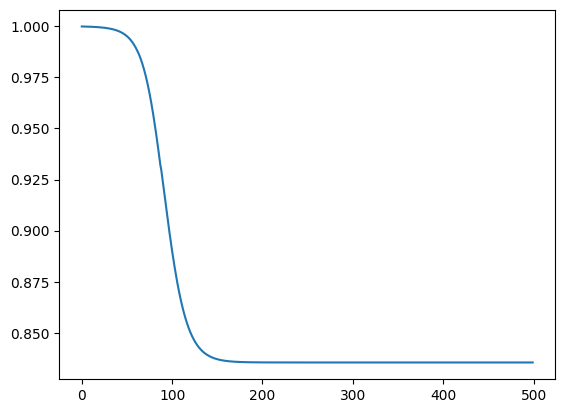

In [443]:
plt.plot(losses)

In [444]:
(losses[-1], unitary_scores[-1])

(0.8354546204454707, 0.0041399572261822115)

Extract cohomology phases

In [445]:
extract_left_right_cohomology_phases(
    data_b09_sl_w2[3],
    data_b09_sr_w2[3],
    data_b09_sl_w2[4],
    data_b09_sr_w2[4]
)

((-1+8.554070147107307e-17j), (-1+0j))

In [446]:
extract_left_right_cohomology_phases(
    data_b09_sl_w2[3],
    data_b09_sb_w2[3],
    data_b09_sl_w2[4],
    data_b09_sb_w2[4]
)

((-1+9.667026721641738e-17j), (-1+5.570590502882728e-17j))

In [447]:
extract_left_right_cohomology_phases(
    data_b09_sr_w2[3],
    data_b09_sb_w2[3],
    data_b09_sr_w2[4],
    data_b09_sb_w2[4]
)

((-1-4.151593319227599e-17j), (-1+2.7567114386974248e-17j))

### B=1.1

In [448]:
psi_11 = next(
    d['wavefunction']
    for d in loaded_data
    if d['paramters']['B'] == 1.1
)   

In [452]:
data_b11_sl_w2 = grad_descent_setup(psi_11, 2, [np_X, np_I]*30)

In [453]:
for _ in range(500):
    grad_descent_step(*data_b11_sl_w2, eta=0.1)

In [454]:
(*_, losses, unitary_scores) = data_b11_sl_w2

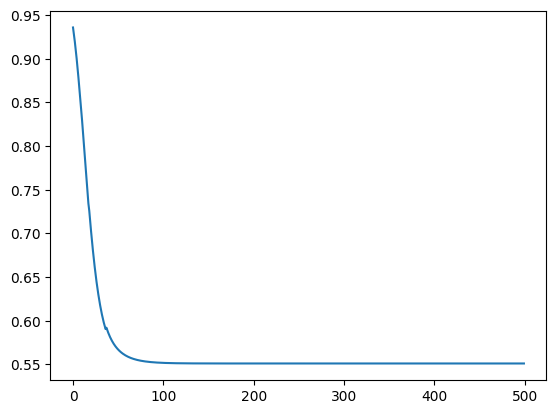

In [455]:
plt.plot(losses)

In [456]:
(losses[-1], unitary_scores[-1])

(0.5508770573736291, 0.0022556658046062328)

In [457]:
data_b11_sr_w2 = grad_descent_setup(psi_11, 2, [np_I, np_X]*30)

In [458]:
for _ in range(500):
    grad_descent_step(*data_b11_sr_w2, eta=0.1)

In [459]:
(*_, losses, unitary_scores) = data_b11_sr_w2

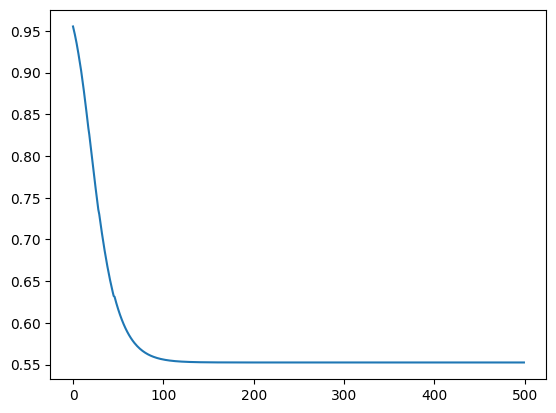

In [460]:
plt.plot(losses)

In [461]:
(losses[-1], unitary_scores[-1])

(0.5524292204259074, 0.004142732677526073)

In [462]:
data_b11_sb_w2 = grad_descent_setup(psi_11, 2, [np_X, np_X]*30)

In [463]:
for _ in range(500):
    grad_descent_step(*data_b11_sb_w2, eta=0.1)

In [464]:
(*_, losses, unitary_scores) = data_b11_sb_w2

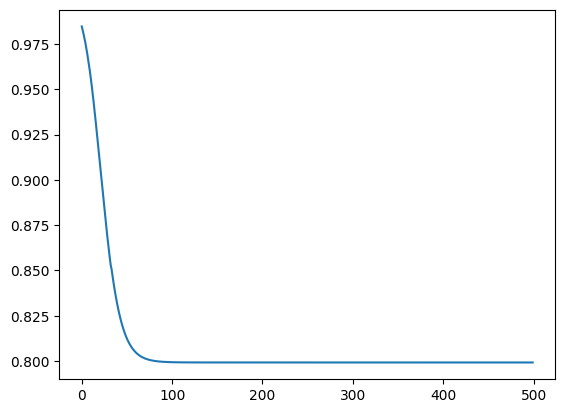

In [465]:
plt.plot(losses)

In [466]:
(losses[-1], unitary_scores[-1])

(0.7991723656158981, 0.0030952929775180937)

Extract cohomology phases

In [467]:
extract_left_right_cohomology_phases(
    data_b11_sl_w2[3],
    data_b11_sr_w2[3],
    data_b11_sl_w2[4],
    data_b11_sr_w2[4]
)

((1-5.5379015923639576e-17j), (1-4.1547646739246686e-17j))

In [468]:
extract_left_right_cohomology_phases(
    data_b11_sl_w2[3],
    data_b11_sb_w2[3],
    data_b11_sl_w2[4],
    data_b11_sb_w2[4]
)

((1-4.1581942719849055e-17j), (1+2.76590727016589e-17j))

In [469]:
extract_left_right_cohomology_phases(
    data_b11_sr_w2[3],
    data_b11_sb_w2[3],
    data_b11_sr_w2[4],
    data_b11_sb_w2[4]
)

((1-2.7747125816421663e-17j), (1-2.42494969546378e-17j))

## B=2

In [147]:
psi_b2 = next(
    d['wavefunction']
    for d in loaded_data
    if d['paramters']['B'] == 2
)   

In [194]:
data_b2_sl = grad_descent_setup(psi_b2, 8, [np_X, np_I]*20)

In [203]:
for _ in range(500):
    grad_descent_step(*data_b2_sl, eta=0.1)

In [204]:
(*_, losses, unitary_scores) = data_b2_sl

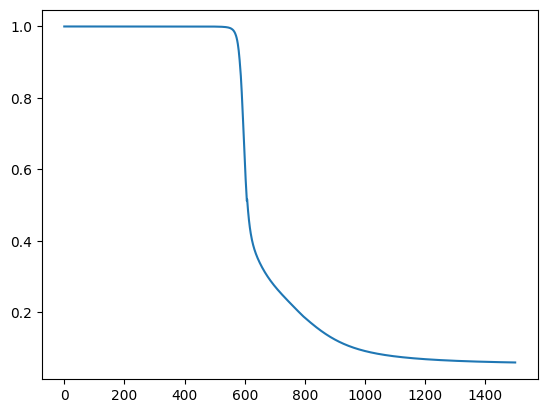

In [205]:
plt.plot(losses)

In [206]:
losses[-1]

0.05960599795016419

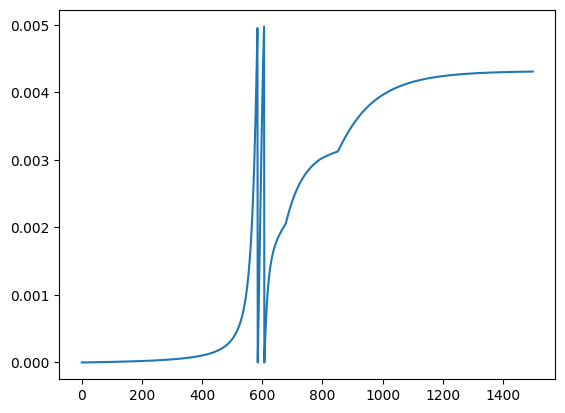

In [207]:
plt.plot(unitary_scores)

In [277]:
data_b2_sr = grad_descent_setup(psi_b2, 8, [np_I, np_X]*20)

In [286]:
for _ in range(100):
    grad_descent_step(*data_b2_sr, eta=0.01)

In [287]:
(*_, losses, unitary_scores) = data_b2_sr

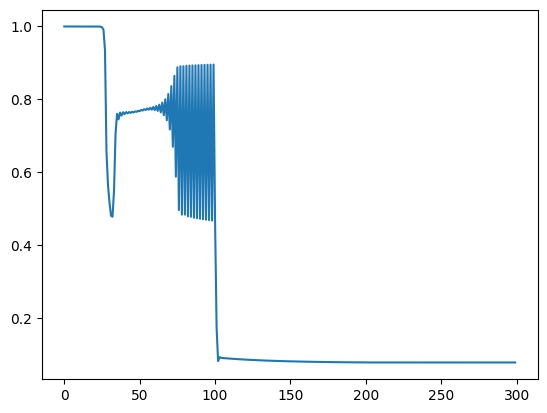

In [288]:
plt.plot(losses)

In [289]:
losses[-1]

0.07835060842494979

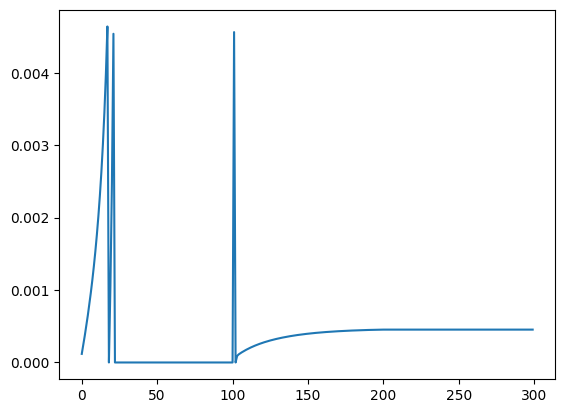

In [290]:
plt.plot(unitary_scores)

In [292]:
data_b2_sb = grad_descent_setup(psi_b2, 8, [np_X, np_X]*20)

In [296]:
for _ in range(100):
    grad_descent_step(*data_b2_sb, eta=0.03)

In [297]:
(*_, losses, unitary_scores) = data_b2_sb

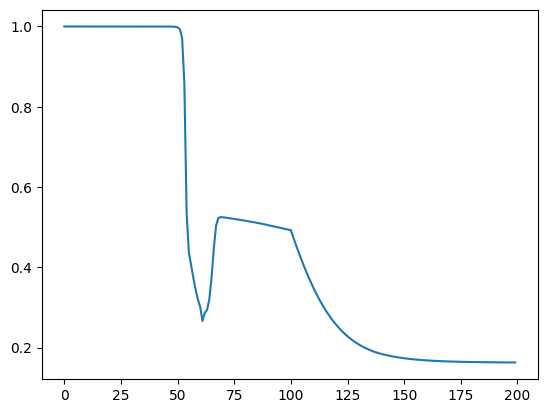

In [298]:
plt.plot(losses)

In [299]:
losses[-1]

0.16302224522649478

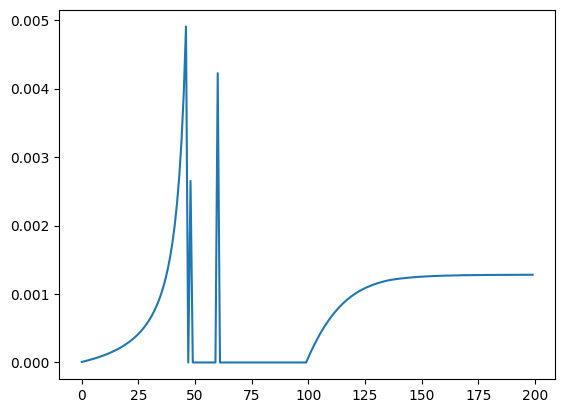

In [300]:
plt.plot(unitary_scores)

In [301]:
extract_left_right_cohomology_phases(
    data_b2_sl[3],
    data_b2_sr[3],
    data_b2_sl[4],
    data_b2_sr[4]
)

((1+3.592437520339363e-18j), (1-5.861598361481182e-17j))

In [302]:
extract_left_right_cohomology_phases(
    data_b2_sl[3],
    data_b2_sb[3],
    data_b2_sl[4],
    data_b2_sb[4]
)

((1-4.0749306578459838e-19j), (1+6.586329295020432e-17j))

In [303]:
extract_left_right_cohomology_phases(
    data_b2_sr[3],
    data_b2_sb[3],
    data_b2_sr[4],
    data_b2_sb[4]
)

((1+1.4093646537662805e-16j), (1+5.022565751916143e-17j))

# Old code

In [116]:
def matrix_element_gradient(psi, symmetry_operations, left_unitaries,
                            right_unitaries, unitary_index, starting_psi_index):
    left_npc_unitaries = [to_npc_array(u) for u in left_unitaries]
    right_npc_unitaries = [to_npc_array(u) for u in right_unitaries]

    assert (unitary_index >= 0) and (unitary_index < len(left_unitaries) + len(right_unitaries))
    if unitary_index < len(left_unitaries):
        left_ops = left_npc_unitaries[:unitary_index]
        right_ops = left_npc_unitaries[unitary_index+1:] + symmetry_operations + right_npc_unitaries
    else:
        shifted_index = unitary_index - len(left_unitaries)
        left_ops = left_npc_unitaries + symmetry_operations + right_npc_unitaries[:shifted_index]
        right_ops = right_npc_unitaries[shifted_index+1:]

    starting_index = get_starting_index(psi, symmetry_operations, left_unitaries, right_unitaries)

    out = np.zeros((2,2),dtype='complex')
    
    for i in range(2):
        for j in range(2):
            delta_U = np.zeros((2,2),dtype='complex')
            delta_U[i,j] = 1
            ops_list = left_ops + [to_npc_array(delta_U),] + right_ops
            out[i,j] = psi.expectation_value_multi_sites(ops_list, starting_psi_index)
    
    return out

In [77]:
def all_matrix_element_gradients(psi, symmetry_operations, left_unitaries, right_unitaries):
    left_outs = list()

    for unitary_index in range(len(left_unitaries)):
        left_outs.append(matrix_element_gradient(psi, symmetry_operations, left_unitaries, right_unitaries, unitary_index))

    right_outs = list()

    for unitary_index in range(len(right_unitaries)):
        right_outs.append(matrix_element_gradient(psi, symmetry_operations, left_unitaries, right_unitaries, unitary_index+len(left_unitaries)))

    return (left_outs, right_outs)

In [149]:
def update(psi, symmetry_operations, left_unitaries, right_unitaries, losses, unitary_test_scores, eta=0.03, unitary_tol = 0.005):
    M = matrix_element(psi, symmetry_operations, left_unitaries, right_unitaries)

    left_gradients, right_gradients = all_matrix_element_gradients(psi, symmetry_operations, left_unitaries, right_unitaries)

    for u,d in zip(left_unitaries, left_gradients):
        grad = -2*M*np.conj(d)
        u += -eta*projector(u, grad)

    for u,d in zip(right_unitaries, right_gradients):
        grad = -2*M*np.conj(d)
        u += -eta*projector(u, grad)

    losses.append(loss(psi, symmetry_operations, left_unitaries, right_unitaries))

    all_unitaries = left_unitaries + right_unitaries

    any_unitary_fail = any(
        unitary_test(u) > unitary_tol
        for u in all_unitaries
    )

    if any_unitary_fail:
        for i in range(len(left_unitaries)):
            u = left_unitaries[i]
            left_unitaries[i] = unitarize_matrix(u)
        for i in range(len(right_unitaries)):
            u = right_unitaries[i]
            right_unitaries[i] = unitarize_matrix(u)

    current_unitary_test_scores = [unitary_test(u) for u in all_unitaries]
    unitary_test_scores.append(current_unitary_test_scores)
    
    pass

In [100]:
def sample_unitaries(n):
    unitary_sampler = unitary_group(2)

    samples = [unitary_sampler.rvs() for _ in range(n)]

    return samples

In [150]:
single_losses = list()
single_unitary_scores = list()

left_unitaries = sample_unitaries(1)
right_unitaries = sample_unitaries(1)

In [167]:
single_symmetry_operations = transverse_cluster_symmetry_operation("single", 10)

In [151]:
for i in range(100):
    update(psi, symmetry_operations, left_unitaries, right_unitaries, single_losses, single_unitary_scores, eta=0.03)

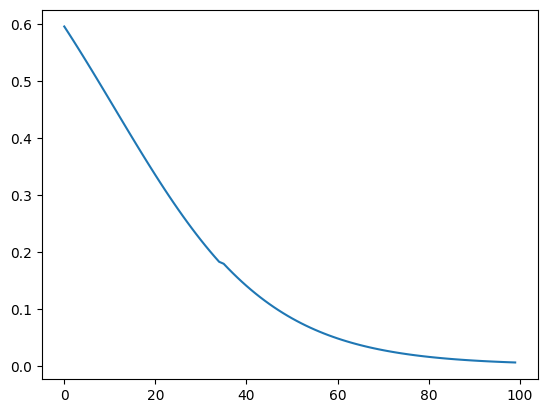

In [152]:
plt.plot(single_losses)

In [153]:
single_losses[-1]

0.006846379175071915

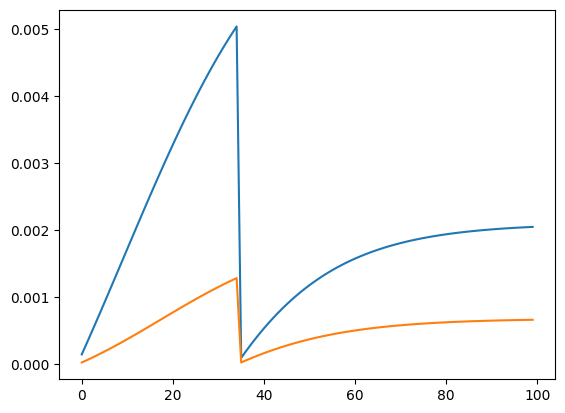

In [154]:
plt.plot(list(zip(*single_unitary_scores))[0])
plt.plot(list(zip(*single_unitary_scores))[1])

extract phase

In [170]:
single_phase = np.conj(matrix_element(psi, single_symmetry_operations, left_unitaries, right_unitaries))

In [37]:
unitary_tol = 0.005

In [38]:
def unitary_test(U):
    return np.max(np.abs(U.conj().T.dot(U)-np.identity(len(U))))

In [39]:
def unitarize_matrix(U):
    L,S,R = np.linalg.svd(U)
    return L.dot(R)

In [156]:
double_losses = list()
double_unitary_scores = list()

double_left_unitaries = sample_unitaries(2)
double_right_unitaries = sample_unitaries(2)

double_symmetry_operations = transverse_cluster_symmetry_operation("both", 10)

In [165]:
for i in range(100):
    update(
        psi,
        double_symmetry_operations,
        double_left_unitaries,
        double_right_unitaries,
        double_losses,
        double_unitary_scores,
        eta=0.03
    )

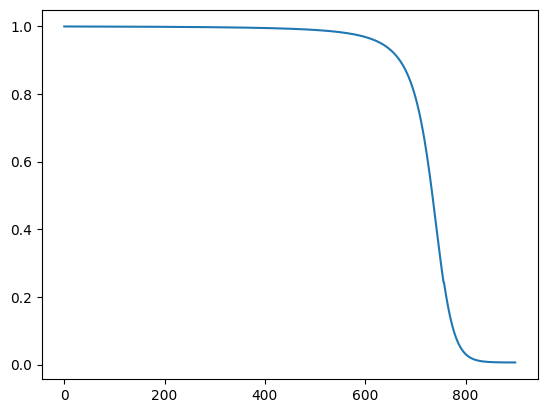

In [166]:
plt.plot(double_losses)

In [171]:
double_phase = np.conj(matrix_element(psi, double_symmetry_operations, double_left_unitaries, double_right_unitaries))

In [172]:
double_phase

(0.6171256903536819+0.7827851758858232j)

# Extract cohomology class

In [178]:
U1 = single_phase*right_unitaries[0]
U2 = double_phase*double_right_unitaries[0]

In [179]:
U1.dot(U2).dot(np.conj(U1.T)).dot(np.conj(U2.T))

array([[-0.98575714-0.06602374j, -0.00320238-0.01708454j],
       [ 0.00320238-0.01708454j, -0.98575714+0.06602374j]])

Close enough to -1... where are the errors coming in?

In [180]:
U1 = single_phase*right_unitaries[0]
U2 = double_phase*double_right_unitaries[1]

In [181]:
U1.dot(U2).dot(np.conj(U1.T)).dot(np.conj(U2.T))

array([[ 0.9876098 -1.14769004e-05j, -0.00226331+1.58932079e-02j],
       [ 0.00226331+1.58932079e-02j,  0.9876098 +1.14769004e-05j]])

But not it's closer to +1...! Although perhaps this comparison doesn't make sense...
I need to work through this analytically.

# Sample losses

In [50]:
random_losses = list()

for i in range(100):
    U1 = unitary_sampler.rvs()
    U2 = unitary_sampler.rvs()
    U3 = unitary_sampler.rvs()
    U4 = unitary_sampler.rvs()

    ops_list = list()

    ops_list.append(to_npc_array(U1))
    ops_list.append(to_npc_array(U2))

    ops_list.extend([npc_X, npc_X]*num_symmetry_site_pairs)
    ops_list.append(to_npc_array(U3))
    ops_list.append(to_npc_array(U4))

    M = psi.expectation_value_multi_sites(ops_list, starting_index-1)

    M_loss = 1-(np.abs(M)**2)
    
    random_losses.append(M_loss)

In [51]:
min(random_losses)

0.9455882983600918